#Conditional GAN - MNIST
> 앞에서의 GAN MNIST
* 굉장히 다양한 범위의 이미지들을 생성
* GAN이 생성하는 이미지를 단일 클래스로 고정하고 이미지를 생성할 수 있다면 굉장이 유용할 것
* ex) 3을 표현하는 숫자를 다양하게 생성해달라고 요청이 가능하다면?
- ex) 훈련데이터에 감정과 얼굴 클래스가 있을때 행복한 얼굴의 표정만 생성해달라고 요청이 가능하다면?

#CGAN
> 구조
- 무슨 클래스로 목표로 하는지 생성자에게 알려주어야함
- 생성기에 SEED와 원하는 이미지를 입력으로 넣어줘야한다는 것
- 판별자는 클래스 레이블과 이미지 사이의 관계까지 학습해야 함
    - 판별자한테도 클래스 레이블에 대한 정보를 같이 제공해줘야 함

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset

import pandas, numpy, random
import matplotlib.pyplot as plt


## DataSet Class

In [2]:
class MnistDataset(Dataset):

    def __init__(self, csv_file):
        self.data_df = pandas.read_csv(csv_file, header=None)
        pass

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, index):
        # image target (label)
        label = self.data_df.iloc[index,0]
        target = torch.zeros((10))
        target[label] = 1.0

        # image data, normalised from 0-255 to 0-1
        image_values = torch.FloatTensor(self.data_df.iloc[index,1:].values) / 255.0

        # return label, image data tensor and target tensor
        return label, image_values, target

    def plot_image(self, index):
        img = self.data_df.iloc[index,1:].values.reshape(28,28)
        plt.title("label = " + str(self.data_df.iloc[index,0]))
        plt.imshow(img, interpolation='none', cmap='Blues')
        pass

    pass

In [3]:
mnist_dataset = MnistDataset('/content/drive/MyDrive/동훈/딥러닝 스터디/GAN/DATA/mnist_train.csv')

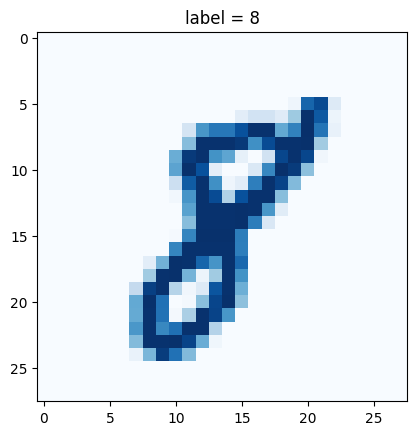

In [4]:
mnist_dataset.plot_image(17)

## Data Function

In [5]:
def generate_random_image(size):
    random_data = torch.rand(size)
    return random_data


def generate_random_seed(size):
    random_data = torch.randn(size)
    return random_data

# size here must only be an integer
def generate_random_one_hot(size):
    label_tensor = torch.zeros((size))
    random_idx = random.randint(0,size-1)
    label_tensor[random_idx] = 1.0
    return label_tensor

# 판별자

## 모델

In [ ]:

class Discriminator(nn.Module):

    def __init__(self):
        # initialise parent pytorch class
        super().__init__()

        # define neural network layers
        self.model = nn.Sequential(
            nn.Linear(784+10, 200),
            nn.LeakyReLU(0.02),

            nn.LayerNorm(200),

            nn.Linear(200, 1),
            nn.Sigmoid()
        )

        # create loss function
        self.loss_function = nn.BCELoss()

        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []

        pass


    def forward(self, image_tensor, label_tensor):
        # combine seed and label
        # torch.cat()을 활용하여 두개의 텐서를 서로 이어준다.
        # 이미지 텐서의 길이 784, 레이블 텐서의 길이 10 으로 총 794의 길이를 가진다.
        inputs = torch.cat((image_tensor, label_tensor))
        return self.model(inputs)


    def train(self, inputs, label_tensor, targets):

        outputs = self.forward(inputs, label_tensor)


        loss = self.loss_function(outputs, targets)


        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass
        if (self.counter % 10000 == 0):
            print("counter = ", self.counter)
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass


    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass

    pass

## 판별자 테스트

In [ ]:
%%time

D = Discriminator()

for label, image_data_tensor, label_tensor in mnist_dataset:
    # real data
    D.train(image_data_tensor, label_tensor, torch.FloatTensor([1.0]))
    # fake data
    D.train(generate_random_image(784), generate_random_one_hot(10), torch.FloatTensor([0.0]))
    pass

In [ ]:
D.plot_progress()

In [ ]:
for i in range(4):
  label, image_data_tensor, label_tensor = mnist_dataset[random.randint(0,60000)]
  print( D.forward( image_data_tensor, label_tensor ).item() )
  pass

for i in range(4):
  print( D.forward( generate_random_image(784), generate_random_one_hot(10) ).item() )
  pass

# 생성자

In [ ]:
class Generator(nn.Module):

    def __init__(self):
        # initialise parent pytorch class
        super().__init__()

        # define neural network layers
        self.model = nn.Sequential(
            nn.Linear(100+10, 200),
            nn.LeakyReLU(0.02),

            nn.LayerNorm(200),

            nn.Linear(200, 784),
            nn.Sigmoid()
        )

        # create optimiser, simple stochastic gradient descent
        self.optimiser = torch.optim.Adam(self.parameters(), lr=0.0001)

        # counter and accumulator for progress
        self.counter = 0;
        self.progress = []

        pass


    def forward(self, seed_tensor, label_tensor):
        # combine seed and label
        inputs = torch.cat((seed_tensor, label_tensor))
        return self.model(inputs)


    def train(self, D, inputs, label_tensor, targets):
        # calculate the output of the network
        g_output = self.forward(inputs, label_tensor)

        # pass onto Discriminator
        d_output = D.forward(g_output, label_tensor)

        # calculate error
        loss = D.loss_function(d_output, targets)

        # increase counter and accumulate error every 10
        self.counter += 1;
        if (self.counter % 10 == 0):
            self.progress.append(loss.item())
            pass

        # zero gradients, perform a backward pass, update weights
        self.optimiser.zero_grad()
        loss.backward()
        self.optimiser.step()

        pass

    def plot_images(self, label):
        label_tensor = torch.zeros((10))
        label_tensor[label] = 1.0

        f, axarr = plt.subplots(2,3, figsize=(16,8))
        for i in range(2):
            for j in range(3):
                axarr[i,j].imshow(G.forward(generate_random_seed(100), label_tensor).detach().cpu().numpy().reshape(28,28), interpolation='none', cmap='Blues')
                pass
            pass
        pass

    def plot_progress(self):
        df = pandas.DataFrame(self.progress, columns=['loss'])
        df.plot(ylim=(0), figsize=(16,8), alpha=0.1, marker='.', grid=True, yticks=(0, 0.25, 0.5, 1.0, 5.0))
        pass

    pass

## 생성자 결과 출력

In [ ]:
G = Generator()

output = G.forward(generate_random_seed(100), generate_random_one_hot(10))

img = output.detach().numpy().reshape(28,28)

plt.imshow(img, interpolation='none', cmap='Blues')

# GAN 학습

In [ ]:
D = Discriminator()
G = Generator()

In [ ]:
%%time

epochs = 12

for epoch in range(epochs):
  print ("epoch = ", epoch + 1)


  for label, image_data_tensor, label_tensor in mnist_dataset:
    # 정상 이미지 -> 1로 판별
    D.train(image_data_tensor, label_tensor, torch.FloatTensor([1.0]))

    # 랜덤 라벨 이용
    random_label = generate_random_one_hot(10)

    # 가짜 이미지 -> 0으로 판별
    # 기울기 계산되지 않도록 detach() 이용
    D.train(G.forward(generate_random_seed(100), random_label).detach(), random_label, torch.FloatTensor([0.0]))

    # 랜덤 라벨 이용
    random_label = generate_random_one_hot(10)

    # 학습
    G.train(D, generate_random_seed(100), random_label, torch.FloatTensor([1.0]))

    pass

  pass

In [ ]:
D.plot_progress()

In [ ]:
G.plot_progress()

# 이미지 생성

In [ ]:
G.plot_images(9)

In [ ]:
G.plot_images(3)

In [ ]:
G.plot_images(1)

In [ ]:
G.plot_images(5)